## Building a model for the MICCAI 2020 HEad and neCK TumOR segmentation challenge [(HECKTOR)](https://www.aicrowd.com/challenges/miccai-2020-hecktor)

In [1]:
import os
import sys
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../src/')
import dataset
import transforms
import losses
import metrics
import trainer
import models

from data import utils

**The path to the directory with preprocessed (resampled and cropped) images (see notebooks/make_dataset.ipynb for details):**

In [3]:
path_to_data = pathlib.Path('C:/inserm/hecktor/hecktor_train/hecktor_nii_resampled/')

**Get paths to all files in the dataset:**

In [4]:
all_paths = utils.get_paths_to_patient_files(path_to_imgs=path_to_data, append_mask=True)

In [5]:
# paths for the first patient
all_paths[0]

(WindowsPath('C:/inserm/hecktor/hecktor_train/hecktor_nii_resampled/CHGJ007/CHGJ007_ct.nii.gz'),
 WindowsPath('C:/inserm/hecktor/hecktor_train/hecktor_nii_resampled/CHGJ007/CHGJ007_pt.nii.gz'),
 WindowsPath('C:/inserm/hecktor/hecktor_train/hecktor_nii_resampled/CHGJ007/CHGJ007_ct_gtvt.nii.gz'))

In [6]:
print(f'Total number of patients: {len(all_paths)}')

Total number of patients: 201


**Split all patients into train and validation folds using IDs saved in pkl files. There are four splits in total.**

In [7]:
# split 0

path_to_pkl = '../src/data/splits/train_val_split_0.pkl'

In [8]:
train_paths, val_paths = utils.get_train_val_paths(all_paths=all_paths, path_to_train_val_pkl=path_to_pkl)

In [9]:
print(f'Total number of patients in TRAIN fold: \t{len(train_paths)}')
print(f'Total number of patients in VAL fold: \t\t{len(val_paths)}')

Total number of patients in TRAIN fold: 	146
Total number of patients in VAL fold: 		55


In this example we will use only a single CPU, so let's keep just a couple of patients for training and validation.

In [10]:
train_paths = train_paths[:2]
val_paths = val_paths[:2]

** Data Transforms:**

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(p=0.5, angle_range=[0, 45]),
    transforms.Mirroring(p=0.5),
    transforms.NormalizeIntensity(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.NormalizeIntensity(),
    transforms.ToTensor()
])

**Datasets and DataLoaders:**

In [12]:
# parameters:

train_batch_size = 1
val_batch_size = 1
num_workers = 2  # for example, use a number of CPU cores

In [13]:
# Datasets:
train_set = dataset.HecktorDataset(train_paths, transforms=train_transforms)
val_set = dataset.HecktorDataset(val_paths, transforms=val_transforms)

# Dataloaders:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=val_batch_size, shuffle=False, num_workers=num_workers)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

**One training sample:**

In [14]:
train_sample = next(iter(train_loader))

In [15]:
train_sample.keys()

dict_keys(['id', 'input', 'target'])

In [16]:
print(f'Patient: \t{train_sample["id"]}')
print(f'Input: \t\t{train_sample["input"].size()}')
print(f'Target: \t{train_sample["target"].size()}')

Patient: 	['CHMR004']
Input: 		torch.Size([1, 2, 144, 144, 144])
Target: 	torch.Size([1, 1, 144, 144, 144])


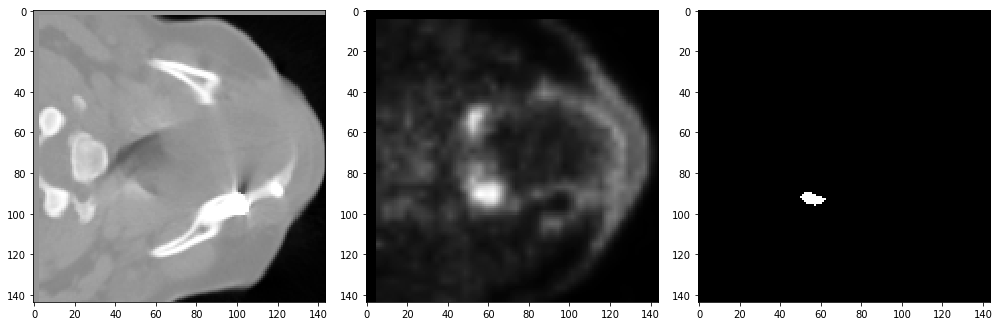

In [17]:
img = train_sample['input'][0]
mask = train_sample['target'][0]

s = 77

fig, axes = plt.subplots(1, 3, figsize=(14, 10))
axes[0].imshow(img[0, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[1].imshow(img[1, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[2].imshow(mask[0, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
plt.tight_layout()
plt.show()

**Training:**

In [18]:
# parameters:

n_cls = 2  # number of classes
lr = 1e-3  # initial learning rate
n_epochs = 2  # number of epochs

**The model described in the paper had *n_filters=24* !**

In [19]:
model = models.FastSmoothSENormDeepUNet_supervision_skip_no_drop(in_channels=2, n_cls=2, n_filters=4)

criterion = losses.Dice_and_FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
metric = metrics.dice
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, eta_min=1e-6)

In [20]:
trainer_ = trainer.ModelTrainer(model=model,
                                dataloaders=dataloaders,
                                criterion=criterion,
                                optimizer=optimizer,
                                metric=metric,
                                scheduler=scheduler,
                                num_epochs=n_epochs,
                                save_last_model=False)

In [21]:
trainer_.train_model()

Start training the model on CPU
Epoch 0 / 1
--------------------
batch: 0 batch loss: 1.209 	metric: 0.014
batch: 1 batch loss: 1.209 	metric: 0.007
TRAIN loss: 1.209 	avg_metric: 0.010
batch: 0 batch loss: 1.144 	metric: 0.036
batch: 1 batch loss: 1.216 	metric: 0.004
VAL loss: 1.180 	avg_metric: 0.020
Epoch 1 / 1
--------------------
batch: 0 batch loss: 1.191 	metric: 0.013
batch: 1 batch loss: 1.197 	metric: 0.009
TRAIN loss: 1.194 	avg_metric: 0.011
batch: 0 batch loss: 1.133 	metric: 0.038
batch: 1 batch loss: 1.211 	metric: 0.004
VAL loss: 1.172 	avg_metric: 0.021


**After training, we need to define a directory to save all results.**

* 'best_model_weights.pt' - weights (state_dict) of the best model received during training on the validation set.
* 'last_model_checkpoint.tar' - the last checkpoint (weights of the last model and the optimizer’s state).
* 'learning_curves.csv' - learning curves.
* 'loss_plot.png', 'metric_plot.png' - plots with the learning curves.
* 'summary.csv' - the short summary.

In [22]:
path_to_save_dir = pathlib.Path('D:/temp/hecktor_training/')

All results have been saved in D:\temp\hecktor_training


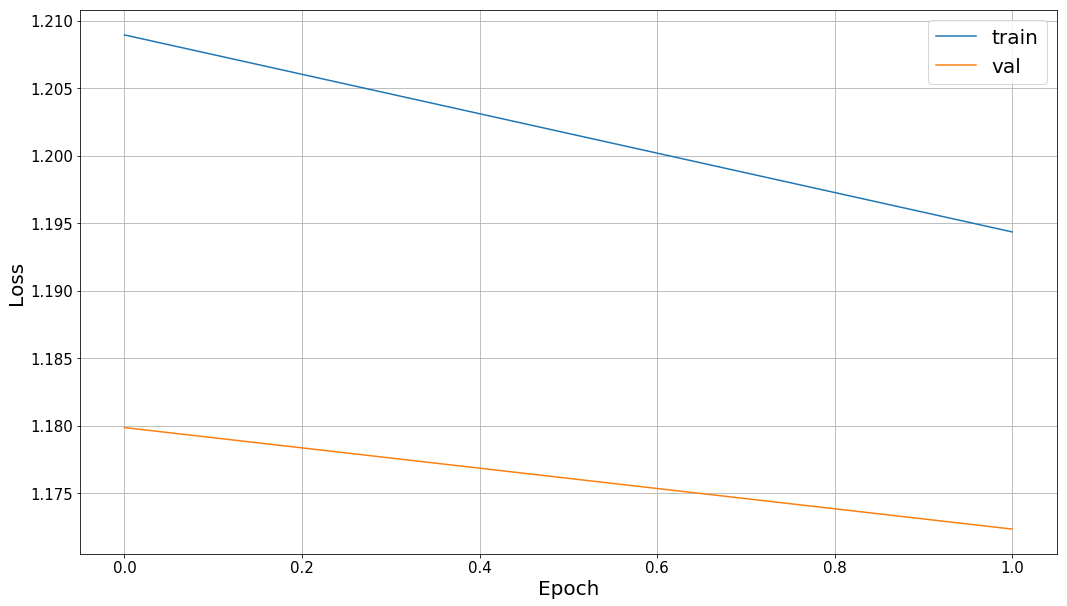

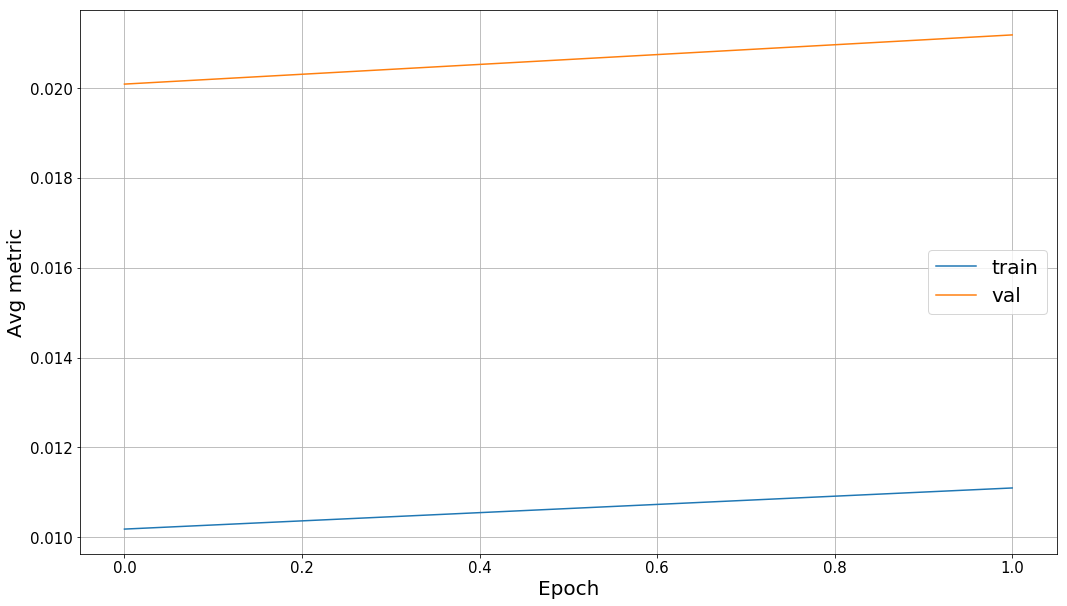

In [23]:
trainer_.save_results(path_to_save_dir)

In [24]:
import pandas as pd

In [25]:
summary = pd.read_csv(path_to_save_dir / 'summary.csv')
summary

,SUMMARY OF THE EXPERIMENT:
0,BEST VAL EPOCH: 1
1,BEST VAL LOSS: 1.1723304390907288
2,BEST VAL AVG metric: 0.02118453406728804
3,BEST VAL metric: 0.02118453406728804
